In [1]:
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from pillow_heif import open_heif
import scipy.stats


def read_image(path, scale=1 / 4):
    try:
        if Path(path).suffix.lower() == ".heic":
            img = open_heif(path, convert_hdr_to_8bit=True)
        else:
            img = Image.open(path)
        rgb = np.asarray(img)
        H, W = rgb.shape[:-1]
        new_H = int(H * scale)
        new_W = int(W * scale)
    except:
        print(path)
        raise
    return cv2.resize(rgb, (new_W, new_H))

def extract_mask(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l = lab[:, :, 0] / 255
    rb_mask = img[:, :, 0] > img[:, :, 2]
    bg_l = scipy.stats.mode(l.reshape(-1)).mode
    cont_mask = (np.abs(l - bg_l) / bg_l) * rb_mask
    return cont_mask

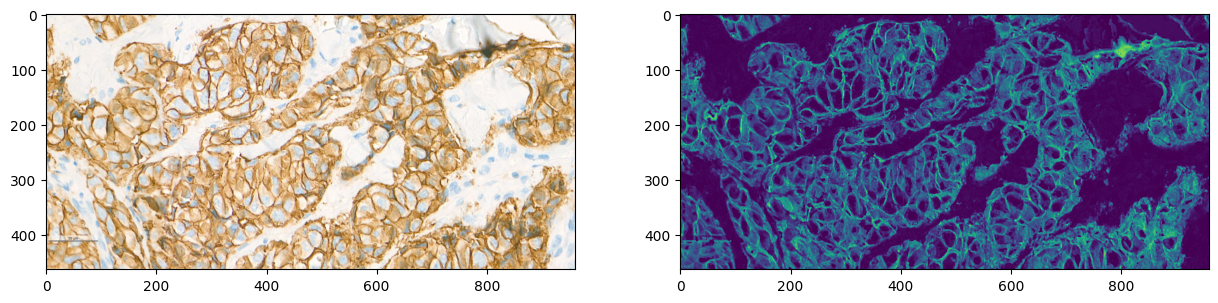

In [8]:
#path = "/home/surayuth/her2/Data_Chula/19 Nov 04 Her2 2+ D+/04 HER2 2+ D+ (1).JPG"
path = "/home/surayuth/her2/Data_Chula/3 April HER2 3+ D+ case 1/HER2 3+ D+_1 (8).jpg"
img = read_image(path, scale=0.5)
cont_mask = extract_mask(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(img)
ax2.imshow(cont_mask)

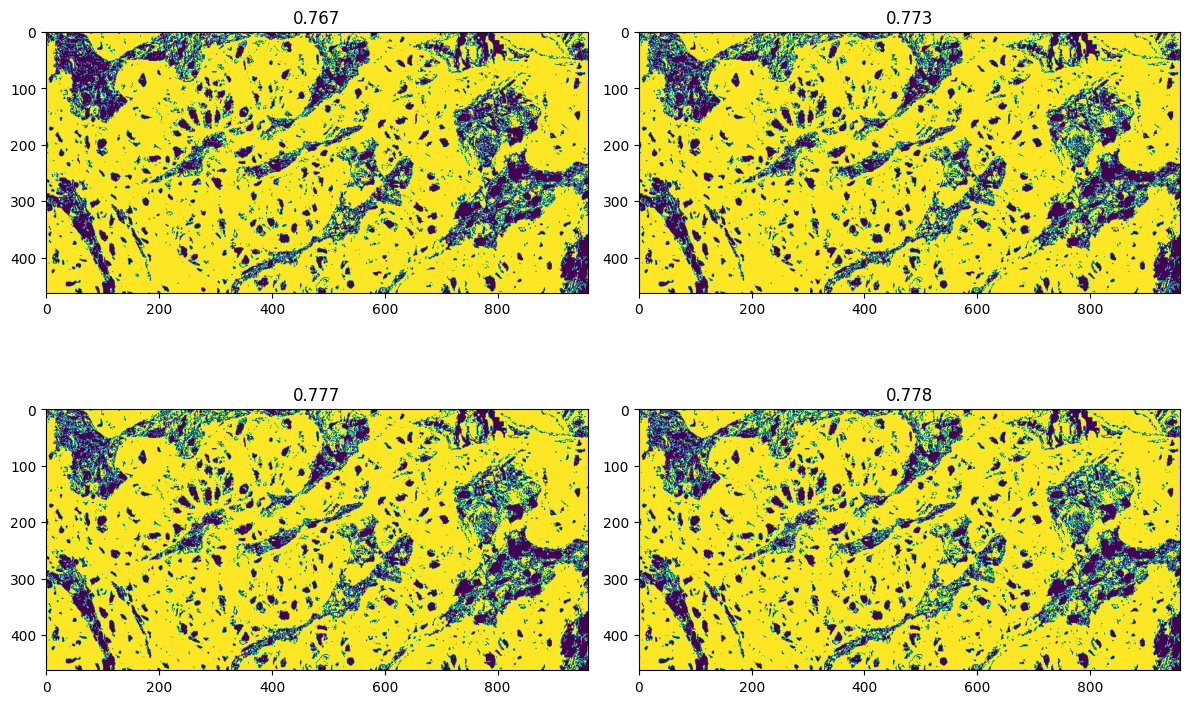

In [20]:
prep_mask = np.round(cont_mask / cont_mask.max() * 255).astype(np.uint8)

th = 10
ksize = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, s in enumerate([4, 8, 16, 32]):
    kernel = np.ones((ksize,ksize),np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2., tileGridSize=(s, s))
    cl1 = clahe.apply(prep_mask)
    h, w= cl1.shape
    cl_mask = cl1 > th
    closing = cl_mask
    #closing = cv2.morphologyEx((cl_mask * 255).astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    area = h * w
    axs[i // 2, i % 2].imshow(closing)
    axs[i // 2, i % 2].set_title(np.round(closing.sum() / area, 3))
    
fig.tight_layout()

<BarContainer object of 256 artists>

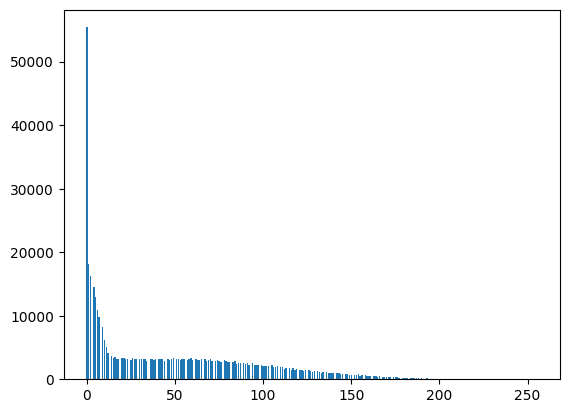

In [21]:
plt.bar(np.arange(256), np.histogram(prep_mask.reshape(-1), 256)[0])

In [25]:
def count_hole(mask, min_area=100):
    analysis = cv2.connectedComponentsWithStats(((~mask) * 255).astype(np.uint8), 
                                                4, 
                                                cv2.CV_32S) 
    (totalLabels, label_ids, values, centroid) = analysis 
    
    # Loop through each component 
    count = 0
    for i in range(1, totalLabels): 
        area = values[i, cv2.CC_STAT_AREA]   
        if (area > min_area) and (area < h * w / 100): 
            count += 1
    return count

count_hole(prep_mask > 10)

116

115


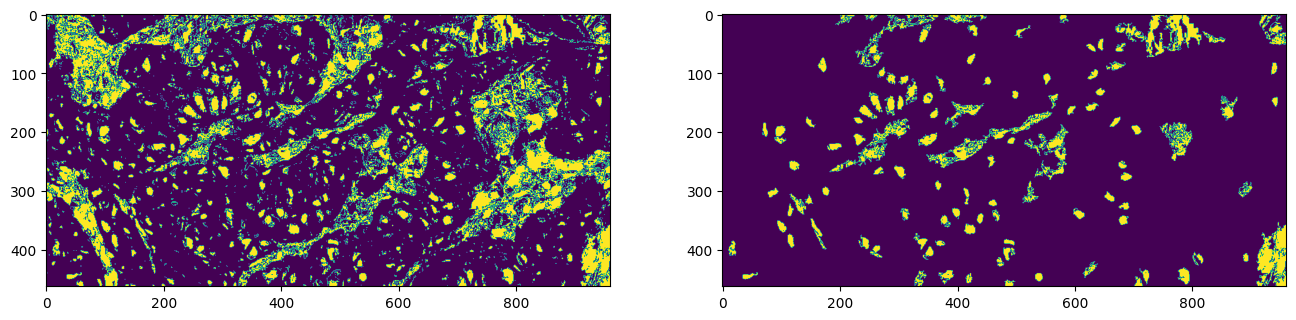

In [22]:
# Apply the Component analysis function 
h, w = closing.shape
pad = 10
analysis = cv2.connectedComponentsWithStats(((~closing) * 255).astype(np.uint8), 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 
  
# Initialize a new image to 
# store all the output components 
output = np.zeros(closing.shape, dtype="uint8")


# Loop through each component 
count = 0
for i in range(1, totalLabels): 
    area = values[i, cv2.CC_STAT_AREA]   
    if (area > 100) and (area < h * w / 100): 
        count += 1
        # Labels stores all the IDs of the components on the each pixel 
        # It has the same dimension as the threshold 
        # So we'll check the component 
        # then convert it to 255 value to mark it white 
        componentMask = (label_ids == i).astype("uint8") * 255
          
        # Creating the Final output mask 
        output = cv2.bitwise_or(output, componentMask) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(~closing)
ax2.imshow(output)
print(count)

In [26]:
holes = []
for i in range(1, 101, 1):
    holes.append(count_hole(prep_mask > i))